In [1]:
import pandas as pd
import numpy as np
import glob
import os.path 
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import folium
from folium.plugins import HeatMap
import requests
import urllib.parse
import datetime
from io import BytesIO
from PIL import Image
import calendar
import IPython.display as display

# Initial Data Import and cleaning

In [2]:
stationdf = pd.read_csv('datasets/station_information.csv')   

stationdf.head()

,Unnamed: 0,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,is_charging_station,rental_methods,groups,obcn,short_name,nearby_distance,_ride_code_support,post_code,is_valet_station,cross_street
0,0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,NaN,Fort York Blvd / Capreol Ct,47,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']",['South'],647-643-9607,647-643-9607,500.0,True,NaN,NaN,NaN
1,1,7001,Wellesley Station Green P,ELECTRICBIKESTATION,43.664964,-79.383550,NaN,Yonge / Wellesley,23,True,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']","['E-Charging ', 'South']",416-617-9576,416-617-9576,500.0,True,M4Y 1G7,NaN,NaN
2,2,7002,St. George St / Bloor St W,REGULAR,43.667131,-79.399555,NaN,St. George St / Bloor St W,17,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']",['South'],647-643-9615,647-643-9615,500.0,True,NaN,NaN,NaN
3,3,7003,Madison Ave / Bloor St W,REGULAR,43.667018,-79.402796,NaN,Madison Ave / Bloor St W,15,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']","['South', 'Bloor St W / Annex']",647-631-4587,647-631-4587,500.0,True,NaN,NaN,NaN
4,4,7005,King St W / York St,REGULAR,43.648001,-79.383177,0.0,King St W / York St,22,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']","['South', 'Financial District']",647-643-9693,647-643-9693,500.0,True,NaN,NaN,NaN


In [3]:
"""
Cleaning:
The first column of `datasets/station_information.csv` corresponds to the label
so it's better to use the pd.read_csv(..., index_col=0) named argument to set the index 
to that column's values
"""

stationdf = pd.read_csv('datasets/station_information.csv', index_col=0)


stationdf.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,is_charging_station,rental_methods,groups,obcn,short_name,nearby_distance,_ride_code_support,post_code,is_valet_station,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,NaN,Fort York Blvd / Capreol Ct,47,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']",['South'],647-643-9607,647-643-9607,500.0,True,NaN,NaN,NaN
1,7001,Wellesley Station Green P,ELECTRICBIKESTATION,43.664964,-79.383550,NaN,Yonge / Wellesley,23,True,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']","['E-Charging ', 'South']",416-617-9576,416-617-9576,500.0,True,M4Y 1G7,NaN,NaN
2,7002,St. George St / Bloor St W,REGULAR,43.667131,-79.399555,NaN,St. George St / Bloor St W,17,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']",['South'],647-643-9615,647-643-9615,500.0,True,NaN,NaN,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667018,-79.402796,NaN,Madison Ave / Bloor St W,15,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']","['South', 'Bloor St W / Annex']",647-631-4587,647-631-4587,500.0,True,NaN,NaN,NaN
4,7005,King St W / York St,REGULAR,43.648001,-79.383177,0.0,King St W / York St,22,False,"['KEY', 'TRANSITCARD', 'CREDITCARD', 'PHONE']","['South', 'Financial District']",647-643-9693,647-643-9693,500.0,True,NaN,NaN,NaN


In [4]:
"""
Cleaning:
Remove columns we don't need
"""

unneeded_cols = ['altitude', 'capacity', 'is_charging_station', 'rental_methods', 'obcn', 'short_name', '_ride_code_support', 'is_valet_station', 'cross_street', 'groups', 'nearby_distance']

cleaned_df = stationdf.drop(columns=unneeded_cols)
cleaned_df

,station_id,name,physical_configuration,lat,lon,address,post_code
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,Fort York Blvd / Capreol Ct,NaN
1,7001,Wellesley Station Green P,ELECTRICBIKESTATION,43.664964,-79.383550,Yonge / Wellesley,M4Y 1G7
2,7002,St. George St / Bloor St W,REGULAR,43.667131,-79.399555,St. George St / Bloor St W,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667018,-79.402796,Madison Ave / Bloor St W,NaN
4,7005,King St W / York St,REGULAR,43.648001,-79.383177,King St W / York St,NaN
...,...,...,...,...,...,...,...
860,8003,Tecumseth St / Tecumseth Pl,VAULT,43.642698,-79.404999,Tecumseth St / Tecumseth Pl,M5V 2R8
861,8008,Brookdale Ave / Yonge St,SMARTMAPFRAME,43.729920,-79.403727,Brookdale Ave/ Yonge St,M5M 1P3
862,8009,1 Shortt St,ELECTRICBIKESTATION,43.695930,-79.451901,1 Shortt St,M6E 2J6
863,8012,Cherry St / Polson St,VAULT,43.643321,-79.351209,Cherry St / Polson St,M5A 1A5


In [5]:
locations = cleaned_df[['station_id', 'lat', 'lon']]
locations

# This dataframe will be used for our bikeshare rider information shortly

,station_id,lat,lon
0,7000,43.639832,-79.395954
1,7001,43.664964,-79.383550
2,7002,43.667131,-79.399555
3,7003,43.667018,-79.402796
4,7005,43.648001,-79.383177
...,...,...,...
860,8003,43.642698,-79.404999
861,8008,43.729920,-79.403727
862,8009,43.695930,-79.451901
863,8012,43.643321,-79.351209


In [6]:
def generate_ridership_csv():
    ridership_csv = glob.glob("datasets/bikeshare-ridership-2023/*.csv")

    ridership_df = pd.concat([pd.read_csv(file, encoding = 'cp1252') for file in ridership_csv], ignore_index = True)

    ridership_df.to_csv("datasets/combined_ridership.csv", index = False)

    print(" Combined CSV files successfully!")

if os.path.isfile("datasets/combined_ridership.csv"):
    print("Combined_ridership.csv file already exists")
else:
    generate_ridership_csv()


Combined_ridership.csv file already exists


In [7]:

# Find the number of total rows to determine our sampling frequency
rows_df = pd.read_csv("datasets/combined_ridership.csv", encoding='cp1252')

row_count = len(rows_df)

print(f"Total number of rows in the CSV: {row_count}")

Total number of rows in the CSV: 5713141


In [8]:
"""
We want a systematic sample of 10,000 rows of data

Therefore, n = 5,713,141 / 10,000

"""
sample_size = 10000
interval = row_count / sample_size

print(f"Interval: {interval}")

Interval: 571.3141


In [9]:
# Use ILOC to pickup every 571 row and create new csv file


sample_df = rows_df.iloc[::571].copy()

if os.path.isfile("datasets/sample_every_571_row.csv"):
    print("sample_every_571_row.csv file already exists")
else:
    sample_df.to_csv("datasets/sample_every_571_row.csv", index=False)
    print("✅ Sampled every 571 row and saved to new file!")



sample_every_571_row.csv file already exists


In [10]:
#Lets see what our data looks like in a PD Dataframe

sample_df.head()

,Ã¯Â»Â¿Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Trip Id
0,20148784.0,840,7022,01/01/2023 00:00,Simcoe St / Queen St W,7703.0,01/01/2023 00:14,NaN,1770,Casual Member,NaN
571,20149414.0,1037,7720,01/01/2023 02:17,NaN,7153.0,01/01/2023 02:34,Bloor St W / Christie St,5514,Casual Member,NaN
1142,20150036.0,134,7148,01/01/2023 05:06,King St W / Joe Shuster Way,7148.0,01/01/2023 05:08,King St W / Joe Shuster Way,1068,Casual Member,NaN
1713,20150702.0,900,7227,01/01/2023 11:18,Martin Goodman Trail (Marilyn Bell Park),7322.0,01/01/2023 11:33,King St W / Brant St,6474,Casual Member,NaN
2284,20151407.0,126,7389,01/01/2023 15:03,College Park- Gerrard Entrance,7012.0,01/01/2023 15:05,Elizabeth St / Edward St (Bus Terminal),3445,Casual Member,NaN


In [11]:
#Split data in Start time so the date and time have their own columns (for start and end date/time)

if ('Start Date' not in sample_df.columns and 'End Date' not in sample_df.columns and 'Time Start' not in sample_df.columns and 'Time End' not in sample_df.columns):
    sample_df.loc[:, 'Start Date'] = pd.to_datetime(sample_df.loc[:, 'Start Time']).dt.date
    sample_df.loc[:, 'Time Start'] = pd.to_datetime(sample_df.loc[:, 'Start Time']).dt.time
    sample_df.loc[:, 'End Date'] = pd.to_datetime(sample_df.loc[:, 'End Time']).dt.date
    sample_df.loc[:, 'Time End'] = pd.to_datetime(sample_df.loc[:, 'End Time']).dt.time


    #Drop old Start time and End Time columns and other irrelevant columns
    sample_df = sample_df.drop(columns=['Start Time', 'End Time', 'Trip Id'])
sample_df.head()

,Ã¯Â»Â¿Trip Id,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,Bike Id,User Type,Start Date,Time Start,End Date,Time End
0,20148784.0,840,7022,Simcoe St / Queen St W,7703.0,NaN,1770,Casual Member,2023-01-01,00:00:00,2023-01-01,00:14:00
571,20149414.0,1037,7720,NaN,7153.0,Bloor St W / Christie St,5514,Casual Member,2023-01-01,02:17:00,2023-01-01,02:34:00
1142,20150036.0,134,7148,King St W / Joe Shuster Way,7148.0,King St W / Joe Shuster Way,1068,Casual Member,2023-01-01,05:06:00,2023-01-01,05:08:00
1713,20150702.0,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322.0,King St W / Brant St,6474,Casual Member,2023-01-01,11:18:00,2023-01-01,11:33:00
2284,20151407.0,126,7389,College Park- Gerrard Entrance,7012.0,Elizabeth St / Edward St (Bus Terminal),3445,Casual Member,2023-01-01,15:03:00,2023-01-01,15:05:00


In [12]:
#Rename columns for better functionality
sample_df.columns = ['Trip id'] + list(sample_df.columns[1:])

sample_df = sample_df.fillna({'Trip id': 0})


In [13]:

#Remove any rows with nan values

sample_df = sample_df.dropna(subset=['Start Station Name', 'End Station Name'])
sample_df.isnull().sum()
sample_df.head()

#Test to see if Trip ID column had 0 filled in on the nan rows
sample_df.to_csv("datasets/test.csv", index = False)


In [14]:
#Merge the latitude and longitude of the start and end bike stations for reference
print(f"{len(sample_df)}")
sample_df.head()

sample_df = pd.merge(sample_df, locations, left_on='Start Station Id', right_on='station_id', how='left')
sample_df

sample_df = pd.merge(sample_df, locations, left_on='End Station Id', right_on='station_id', how='left', suffixes=('_start', '_end'))
sample_df = sample_df.dropna()

sample_df.to_csv("datasets/lon-lat.csv")


8113


In [15]:
# Rearrange columns and column names for easier presentation

new_order = ['Trip id', 'Start Date', 'Time Start', 'End Date', 'Time End', 'Trip  Duration', 'Start Station Id', 'Start Station Name',
             'End Station Id', 'End Station Name', 'User Type', 'Bike Id', 'lat_start', 'lon_start', 'lat_end', 'lon_end']

sample_df = sample_df[new_order]

sample_df.rename(columns={'Trip  Duration': 'Trip Duration (seconds)', 'Start Date': 'Start Date (YYYY-MM-DD)', 'End Date': 'End Date (YYYY-MM-DD)'}, inplace = True)


sample_df.head()

,Trip id,Start Date (YYYY-MM-DD),Time Start,End Date (YYYY-MM-DD),Time End,Trip Duration (seconds),Start Station Id,Start Station Name,End Station Id,End Station Name,User Type,Bike Id,lat_start,lon_start,lat_end,lon_end
0,20150036.0,2023-01-01,05:06:00,2023-01-01,05:08:00,134,7148,King St W / Joe Shuster Way,7148.0,King St W / Joe Shuster Way,Casual Member,1068,43.639444,-79.423611,43.639444,-79.423611
1,20150702.0,2023-01-01,11:18:00,2023-01-01,11:33:00,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322.0,King St W / Brant St,Casual Member,6474,43.631400,-79.430400,43.639278,-79.411574
2,20151407.0,2023-01-01,15:03:00,2023-01-01,15:05:00,126,7389,College Park- Gerrard Entrance,7012.0,Elizabeth St / Edward St (Bus Terminal),Casual Member,3445,43.658938,-79.383518,43.656026,-79.385327
3,20152688.0,2023-01-01,20:42:00,2023-01-01,21:07:00,1493,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7140.0,Macpherson Ave / Spadina Rd,Annual Member,1286,43.635492,-79.398253,43.675791,-79.406980
4,20153366.0,2023-01-02,03:50:00,2023-01-02,03:54:00,295,7238,Sorauren/Geoffrey (Sorauren Park) - SMART,7496.0,Sunnyside Ave / The Queensway - SMART,Annual Member,5511,43.649172,-79.444509,43.639700,-79.448650


In [16]:
#confirm that there are no more missing values
print(sample_df.isnull().sum().sum())


0


In [17]:
#Confirm there are no duplicated rows
print(sample_df.duplicated().sum())

0


In [18]:
#Check data types to see if any need to be changed for accuracy
sample_df.dtypes


Trip id                    float64
Start Date (YYYY-MM-DD)     object
Time Start                  object
End Date (YYYY-MM-DD)       object
Time End                    object
Trip Duration (seconds)      int64
Start Station Id             int64
Start Station Name          object
End Station Id             float64
End Station Name            object
User Type                   object
Bike Id                      int64
lat_start                  float64
lon_start                  float64
lat_end                    float64
lon_end                    float64
dtype: object

In [19]:
#Convert start date and end date from object to datetime

sample_df['Start Date (YYYY-MM-DD)'] = pd.to_datetime(sample_df['Start Date (YYYY-MM-DD)'], format = '%Y-%m-%d')
sample_df['End Date (YYYY-MM-DD)'] = pd.to_datetime(sample_df['End Date (YYYY-MM-DD)'], format = '%Y-%m-%d')
sample_df['Time Start'] = pd.to_datetime(sample_df['Time Start'], format = '%H:%M:%S')
sample_df['Time End'] = pd.to_datetime(sample_df['Time End'], format = '%H:%M:%S')

sample_df.dtypes

Trip id                           float64
Start Date (YYYY-MM-DD)    datetime64[ns]
Time Start                 datetime64[ns]
End Date (YYYY-MM-DD)      datetime64[ns]
Time End                   datetime64[ns]
Trip Duration (seconds)             int64
Start Station Id                    int64
Start Station Name                 object
End Station Id                    float64
End Station Name                   object
User Type                          object
Bike Id                             int64
lat_start                         float64
lon_start                         float64
lat_end                           float64
lon_end                           float64
dtype: object

In [20]:
#Confirm columns are correct data types

sample_df.dtypes

Trip id                           float64
Start Date (YYYY-MM-DD)    datetime64[ns]
Time Start                 datetime64[ns]
End Date (YYYY-MM-DD)      datetime64[ns]
Time End                   datetime64[ns]
Trip Duration (seconds)             int64
Start Station Id                    int64
Start Station Name                 object
End Station Id                    float64
End Station Name                   object
User Type                          object
Bike Id                             int64
lat_start                         float64
lon_start                         float64
lat_end                           float64
lon_end                           float64
dtype: object

In [21]:
# Data is now fully cleaned, lets move on to data analysis

# Data Analysis and Visualizations 

In [22]:
#Look at the breakdown of casual members vs annual members
user_type_counts_df = sample_df['User Type'].value_counts().reset_index()
user_type_counts_df.columns = ['User Type', 'Count']
print(user_type_counts_df)

       User Type  Count
0  Casual Member   7023
1  Annual Member    468


In [23]:
#Table showing riders by month, as well as the percentage of the overall rides

sample_df['Month'] = sample_df['Start Date (YYYY-MM-DD)'].dt.to_period('M')

#Group by Month and get count

start_date_by_month = sample_df.groupby('Month').size().reset_index(name='Count')
# Calculate the percentage for each month
start_date_by_month['Percentage'] = (start_date_by_month['Count'] / start_date_by_month['Count'].sum()) * 100

# Add a total row
total_row = pd.DataFrame({'Month': ['Total'], 'Count': [start_date_by_month['Count'].sum()], 'Percentage': [100]})
start_date_by_month = pd.concat([start_date_by_month, total_row], ignore_index=True)

print(start_date_by_month)

      Month  Count  Percentage
0   2023-01    238    3.177146
1   2023-02    240    3.203845
2   2023-03    303    4.044854
3   2023-04    524    6.995061
4   2023-05    794   10.599386
5   2023-06    868   11.587238
6   2023-07    959   12.802029
7   2023-08    976   13.028968
8   2023-09    984   13.135763
9   2023-10    775   10.345748
10  2023-11    505    6.741423
11  2023-12    325    4.338540
12    Total   7491  100.000000


In [24]:
# •	Identify fluctuations in bike usage throughout the year, comparing peak and off-peak seasons.

#Table showing riders by month, as well as the percentage of the overall rides

sample_df['Month'] = sample_df['Start Date (YYYY-MM-DD)'].dt.to_period('M').astype(str)

#Group by Month and get count

start_date_by_month_user = sample_df.groupby(['Month', 'User Type']).size().reset_index(name='Count')

# Calculate the percentage for each month
start_date_by_month_user['Percentage'] = (start_date_by_month_user['Count'] / start_date_by_month_user['Count'].sum()) * 100


# Add a total row for each User Type
total_row = start_date_by_month_user.groupby('User Type').sum().reset_index()
total_row['Month'] = 'Total'
total_row['Percentage'] = 100

# Add a grand total row for all users
grand_total_row = pd.DataFrame({'Month': ['Total'], 'User Type': ['All'], 'Count': [start_date_by_month_user['Count'].sum()], 'Percentage': [100]})

# Combine everything
final_table = pd.concat([start_date_by_month_user, total_row, grand_total_row], ignore_index=True)

# Display the result

display.display(final_table)

,Month,User Type,Count,Percentage
0,2023-01,Annual Member,83,1.107996
1,2023-01,Casual Member,155,2.069150
2,2023-02,Annual Member,50,0.667468
3,2023-02,Casual Member,190,2.536377
4,2023-03,Annual Member,62,0.827660
5,2023-03,Casual Member,241,3.217194
6,2023-04,Annual Member,96,1.281538
7,2023-04,Casual Member,428,5.713523
8,2023-05,Annual Member,108,1.441730
9,2023-05,Casual Member,686,9.157656


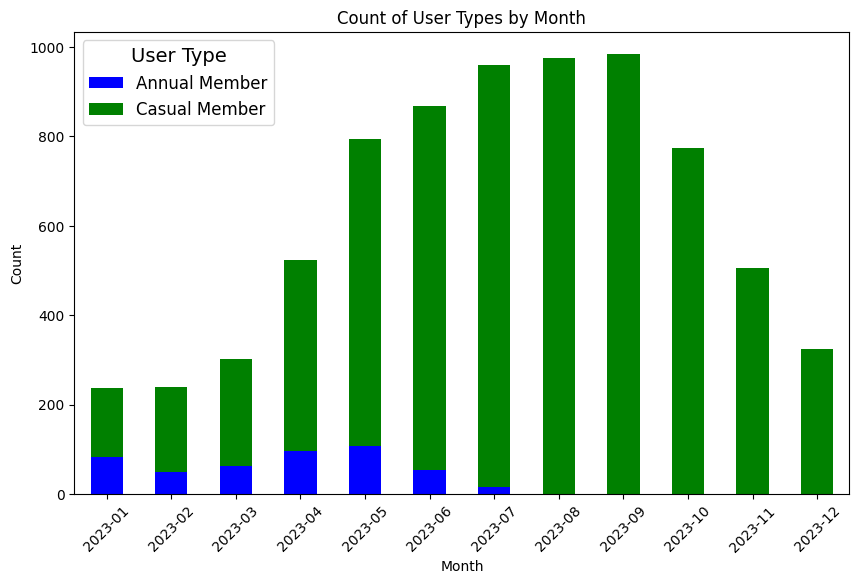

In [25]:
#Create bar chart with riders broken down per month

bar_chart_users = final_table.drop(columns='Percentage')  # Drop the 'Percentage' column if it exists

# Filter out the 'Total' row
bar_chart_users = bar_chart_users[bar_chart_users['Month'] != 'Total']

# Pivot the table to have 'User Type' as columns
bar_chart_users_pivot = bar_chart_users.pivot_table(index='Month', columns='User Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the bar chart with stacking enabled
bar_chart = bar_chart_users_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'green'])

# Adding labels and title
plt.title('Count of User Types by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='User Type', loc='upper left', labels=['Annual Member', 'Casual Member'], fontsize=12, title_fontsize=14)


# Display the plot
plt.show()
    
fig = bar_chart.get_figure()
fig.savefig('images/fig1.png')

In [26]:
#•	Analyze daily and hourly ridership patterns to determine high-demand periods, especially during commute hours.

#Look at the day of the week for our sample

day_of_week = sample_df["Start Date (YYYY-MM-DD)"].dt.day_name()
sample_df['Day of Week'] = sample_df['Start Date (YYYY-MM-DD)'].dt.day_name()
sample_df.head()

,Trip id,Start Date (YYYY-MM-DD),Time Start,End Date (YYYY-MM-DD),Time End,Trip Duration (seconds),Start Station Id,Start Station Name,End Station Id,End Station Name,User Type,Bike Id,lat_start,lon_start,lat_end,lon_end,Month,Day of Week
0,20150036.0,2023-01-01,1900-01-01 05:06:00,2023-01-01,1900-01-01 05:08:00,134,7148,King St W / Joe Shuster Way,7148.0,King St W / Joe Shuster Way,Casual Member,1068,43.639444,-79.423611,43.639444,-79.423611,2023-01,Sunday
1,20150702.0,2023-01-01,1900-01-01 11:18:00,2023-01-01,1900-01-01 11:33:00,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322.0,King St W / Brant St,Casual Member,6474,43.631400,-79.430400,43.639278,-79.411574,2023-01,Sunday
2,20151407.0,2023-01-01,1900-01-01 15:03:00,2023-01-01,1900-01-01 15:05:00,126,7389,College Park- Gerrard Entrance,7012.0,Elizabeth St / Edward St (Bus Terminal),Casual Member,3445,43.658938,-79.383518,43.656026,-79.385327,2023-01,Sunday
3,20152688.0,2023-01-01,1900-01-01 20:42:00,2023-01-01,1900-01-01 21:07:00,1493,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7140.0,Macpherson Ave / Spadina Rd,Annual Member,1286,43.635492,-79.398253,43.675791,-79.406980,2023-01,Sunday
4,20153366.0,2023-01-02,1900-01-01 03:50:00,2023-01-02,1900-01-01 03:54:00,295,7238,Sorauren/Geoffrey (Sorauren Park) - SMART,7496.0,Sunnyside Ave / The Queensway - SMART,Annual Member,5511,43.649172,-79.444509,43.639700,-79.448650,2023-01,Monday


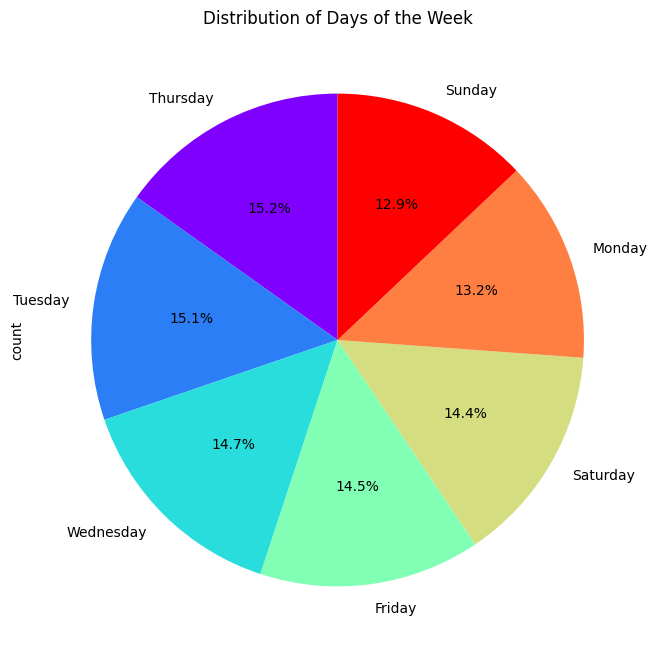

In [27]:
#Pie chart to show frenquency of ridership based on day of week
day_counts = sample_df['Day of Week'].value_counts()

# Plot the pie chart
pie = day_counts.plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', startangle=90, cmap='rainbow')

# Adding title
plt.title('Distribution of Days of the Week')

# Display the plot
plt.show()
fig = pie.get_figure()
fig.savefig('images/fig2.png')

In [28]:
"""
Analysis of days of week:


It is very interesting to see that the rider volume is consistent every day of the week. This suggests that the program is used by people for a variety of purposes. The decrease of weekday commuters is 
replaced by people who are getting around the city to go to different venues on weekends.

"""

'\nAnalysis of days of week:\n\n\nIt is very interesting to see that the rider volume is consistent every day of the week. This suggests that the program is used by people for a variety of purposes. The decrease of weekday commuters is \nreplaced by people who are getting around the city to go to different venues on weekends.\n\n'

In [29]:
#Analysis of ridership based on start time of rides (irrigardless of day of week)
sample_df['day_start'] = sample_df['Time Start'].apply(lambda x: pd.Timedelta(f'{x.hour}:{x.minute}:{x.second}'))


sample_df['day_start_hour'] = sample_df['day_start'].dt.components.hours
sample_df['day_start_minute'] = sample_df['day_start'].dt.components.minutes
sample_df['day_start_seconds'] = sample_df['day_start'].dt.components.seconds
sample_df

,Trip id,Start Date (YYYY-MM-DD),Time Start,End Date (YYYY-MM-DD),Time End,Trip Duration (seconds),Start Station Id,Start Station Name,End Station Id,End Station Name,...,lat_start,lon_start,lat_end,lon_end,Month,Day of Week,day_start,day_start_hour,day_start_minute,day_start_seconds
0,20150036.0,2023-01-01,1900-01-01 05:06:00,2023-01-01,1900-01-01 05:08:00,134,7148,King St W / Joe Shuster Way,7148.0,King St W / Joe Shuster Way,...,43.639444,-79.423611,43.639444,-79.423611,2023-01,Sunday,0 days 05:06:00,5,6,0
1,20150702.0,2023-01-01,1900-01-01 11:18:00,2023-01-01,1900-01-01 11:33:00,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322.0,King St W / Brant St,...,43.631400,-79.430400,43.639278,-79.411574,2023-01,Sunday,0 days 11:18:00,11,18,0
2,20151407.0,2023-01-01,1900-01-01 15:03:00,2023-01-01,1900-01-01 15:05:00,126,7389,College Park- Gerrard Entrance,7012.0,Elizabeth St / Edward St (Bus Terminal),...,43.658938,-79.383518,43.656026,-79.385327,2023-01,Sunday,0 days 15:03:00,15,3,0
3,20152688.0,2023-01-01,1900-01-01 20:42:00,2023-01-01,1900-01-01 21:07:00,1493,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7140.0,Macpherson Ave / Spadina Rd,...,43.635492,-79.398253,43.675791,-79.406980,2023-01,Sunday,0 days 20:42:00,20,42,0
4,20153366.0,2023-01-02,1900-01-01 03:50:00,2023-01-02,1900-01-01 03:54:00,295,7238,Sorauren/Geoffrey (Sorauren Park) - SMART,7496.0,Sunnyside Ave / The Queensway - SMART,...,43.649172,-79.444509,43.639700,-79.448650,2023-01,Monday,0 days 03:50:00,3,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,26674866.0,2023-12-30,1900-01-01 17:05:00,2023-12-30,1900-01-01 17:18:00,755,7016,Bay St / Queens Quay W (Ferry Terminal),7171.0,Ontario Place Blvd / Lake Shore Blvd W (East),...,43.640978,-79.376785,43.632244,-79.410810,2023-12,Saturday,0 days 17:05:00,17,5,0
8108,26675490.0,2023-12-30,1900-01-01 18:17:00,2023-12-30,1900-01-01 18:29:00,678,7534,Walnut Ave / Queen St W,7334.0,Simcoe St / Wellington St North,...,43.645469,-79.411084,43.646218,-79.385505,2023-12,Saturday,0 days 18:17:00,18,17,0
8109,26676732.0,2023-12-30,1900-01-01 22:05:00,2023-12-30,1900-01-01 22:13:00,500,7034,Church St / Bloor St E,7001.0,Wellesley Station Green P,...,43.671389,-79.382919,43.664964,-79.383550,2023-12,Saturday,0 days 22:05:00,22,5,0
8110,26678773.0,2023-12-31,1900-01-01 11:46:00,2023-12-31,1900-01-01 11:54:00,483,7269,Toronto Eaton Centre (Yonge St),7324.0,King St W / Charlotte St (West Side),...,43.655431,-79.380653,43.645572,-79.393990,2023-12,Sunday,0 days 11:46:00,11,46,0


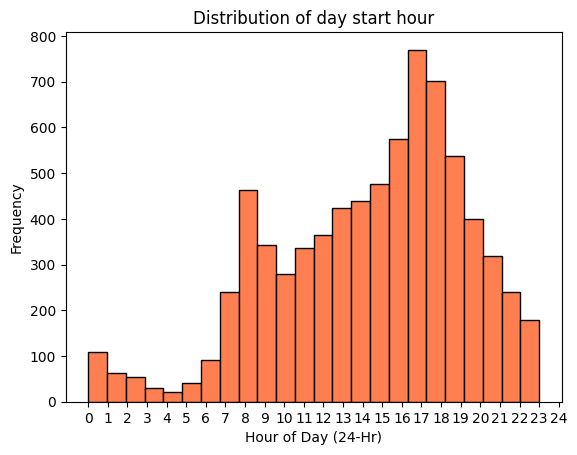

In [30]:


# showing most busy bike use hours.
f = sample_df['day_start_hour'].plot(kind='hist', bins=24, color='coral', edgecolor = 'black')

# Plot Histogram with Colors
plt.xlabel('Hour of Day (24-Hr)') #X-axis label
plt.ylabel('Frequency')
plt.xticks(range(0, 25, 1))
plt.title('Distribution of day start hour')

plt.savefig('images/fig3.png')

plt.show()



In [31]:
"""
The modality of the data's distribution is bimodal, corresponding to the hours 8-9am and 5-6pm, which follows the expected rush hour patterns in the City of Toronto. 

See following code snippit below for modality figures.

"""

"\nThe modality of the data's distribution is bimodal, corresponding to the hours 8-9am and 5-6pm, which follows the expected rush hour patterns in the City of Toronto. \n\nSee following code snippit below for modality figures.\n\n"

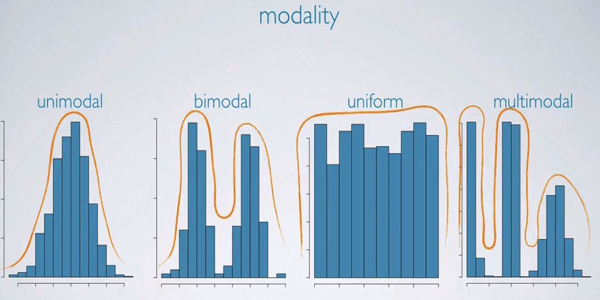

In [32]:


url = 'https://raw.githubusercontent.com/leonkag/Statistics0/main/UniBiMultiModal.jpg'
page = requests.get(url)
img = Image.open(BytesIO(page.content))
img.resize((600, 300))




In [33]:
sample_df.dtypes

Trip id                            float64
Start Date (YYYY-MM-DD)     datetime64[ns]
Time Start                  datetime64[ns]
End Date (YYYY-MM-DD)       datetime64[ns]
Time End                    datetime64[ns]
Trip Duration (seconds)              int64
Start Station Id                     int64
Start Station Name                  object
End Station Id                     float64
End Station Name                    object
User Type                           object
Bike Id                              int64
lat_start                          float64
lon_start                          float64
lat_end                            float64
lon_end                            float64
Month                               object
Day of Week                         object
day_start                  timedelta64[ns]
day_start_hour                       int64
day_start_minute                     int64
day_start_seconds                    int64
dtype: object

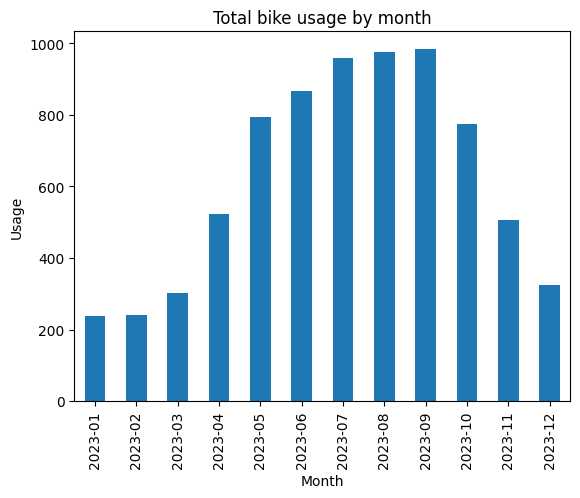

In [34]:

fig4 = sample_df.groupby('Month')['Month'].count()
fig4.plot(kind='bar' )

plt.xlabel('Month')
plt.ylabel('Usage')
plt.title('Total bike usage by month')
plt.savefig('images/fig4.png', bbox_inches='tight')

plt.show()


#print(sample_df.groupby('Month')['day_start_hour'].describe())  # Get min/max/mean

In [35]:
sample_df['Month'] = pd.to_datetime(sample_df['Month'], format='%Y-%m')

In [36]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
sample_df['Season'] = sample_df['Month'].dt.month.map(get_season)

sample_df

,Trip id,Start Date (YYYY-MM-DD),Time Start,End Date (YYYY-MM-DD),Time End,Trip Duration (seconds),Start Station Id,Start Station Name,End Station Id,End Station Name,...,lon_start,lat_end,lon_end,Month,Day of Week,day_start,day_start_hour,day_start_minute,day_start_seconds,Season
0,20150036.0,2023-01-01,1900-01-01 05:06:00,2023-01-01,1900-01-01 05:08:00,134,7148,King St W / Joe Shuster Way,7148.0,King St W / Joe Shuster Way,...,-79.423611,43.639444,-79.423611,2023-01-01,Sunday,0 days 05:06:00,5,6,0,Winter
1,20150702.0,2023-01-01,1900-01-01 11:18:00,2023-01-01,1900-01-01 11:33:00,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322.0,King St W / Brant St,...,-79.430400,43.639278,-79.411574,2023-01-01,Sunday,0 days 11:18:00,11,18,0,Winter
2,20151407.0,2023-01-01,1900-01-01 15:03:00,2023-01-01,1900-01-01 15:05:00,126,7389,College Park- Gerrard Entrance,7012.0,Elizabeth St / Edward St (Bus Terminal),...,-79.383518,43.656026,-79.385327,2023-01-01,Sunday,0 days 15:03:00,15,3,0,Winter
3,20152688.0,2023-01-01,1900-01-01 20:42:00,2023-01-01,1900-01-01 21:07:00,1493,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7140.0,Macpherson Ave / Spadina Rd,...,-79.398253,43.675791,-79.406980,2023-01-01,Sunday,0 days 20:42:00,20,42,0,Winter
4,20153366.0,2023-01-02,1900-01-01 03:50:00,2023-01-02,1900-01-01 03:54:00,295,7238,Sorauren/Geoffrey (Sorauren Park) - SMART,7496.0,Sunnyside Ave / The Queensway - SMART,...,-79.444509,43.639700,-79.448650,2023-01-01,Monday,0 days 03:50:00,3,50,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,26674866.0,2023-12-30,1900-01-01 17:05:00,2023-12-30,1900-01-01 17:18:00,755,7016,Bay St / Queens Quay W (Ferry Terminal),7171.0,Ontario Place Blvd / Lake Shore Blvd W (East),...,-79.376785,43.632244,-79.410810,2023-12-01,Saturday,0 days 17:05:00,17,5,0,Winter
8108,26675490.0,2023-12-30,1900-01-01 18:17:00,2023-12-30,1900-01-01 18:29:00,678,7534,Walnut Ave / Queen St W,7334.0,Simcoe St / Wellington St North,...,-79.411084,43.646218,-79.385505,2023-12-01,Saturday,0 days 18:17:00,18,17,0,Winter
8109,26676732.0,2023-12-30,1900-01-01 22:05:00,2023-12-30,1900-01-01 22:13:00,500,7034,Church St / Bloor St E,7001.0,Wellesley Station Green P,...,-79.382919,43.664964,-79.383550,2023-12-01,Saturday,0 days 22:05:00,22,5,0,Winter
8110,26678773.0,2023-12-31,1900-01-01 11:46:00,2023-12-31,1900-01-01 11:54:00,483,7269,Toronto Eaton Centre (Yonge St),7324.0,King St W / Charlotte St (West Side),...,-79.380653,43.645572,-79.393990,2023-12-01,Sunday,0 days 11:46:00,11,46,0,Winter


In [37]:
season_df = sample_df.groupby(['Season', 'Month']).size().reset_index(name='Count')

In [38]:
season_df['Month_Number'] = season_df['Month'].dt.month


season_map = {
    0: "Winter", 1: "Winter", 11: "Winter",  # Dec, Jan, Feb
    2: "Spring", 3: "Spring", 4: "Spring",  # Mar, Apr, May
    5: "Summer", 6: "Summer", 7: "Summer",  # Jun, Jul, Aug
    8: "Fall", 9: "Fall", 10: "Fall"        # Sep, Oct, Nov
}

def month_num_to_name(x):
    if x in [12, 1, 2]:  # Dec, Jan, Feb -> Winter
        return 'Winter'
    elif x in [3, 4, 5]:  # Mar, Apr, May -> Spring
        return 'Spring'
    elif x in [6, 7, 8]:  # Jun, Jul, Aug -> Summer
        return 'Summer'
    elif x in [9, 10, 11]:  # Sep, Oct, Nov -> Fall
        return 'Fall'

# Apply function to get the Season column
# season_df['Season'] = season_df['Month_Number'].apply(month_num_to_name)
season_df.loc[season_df['Month_Number'] == 12, 'Month_Number'] = 0
season_df = season_df.sort_values(by='Month_Number')
season_df

season_df['Month_Name'] = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
season_df

,Season,Month,Count,Month_Number,Month_Name
11,Winter,2023-12-01,325,0,Dec
9,Winter,2023-01-01,238,1,Jan
10,Winter,2023-02-01,240,2,Feb
3,Spring,2023-03-01,303,3,Mar
4,Spring,2023-04-01,524,4,Apr
5,Spring,2023-05-01,794,5,May
6,Summer,2023-06-01,868,6,Jun
7,Summer,2023-07-01,959,7,Jul
8,Summer,2023-08-01,976,8,Aug
0,Fall,2023-09-01,984,9,Sep


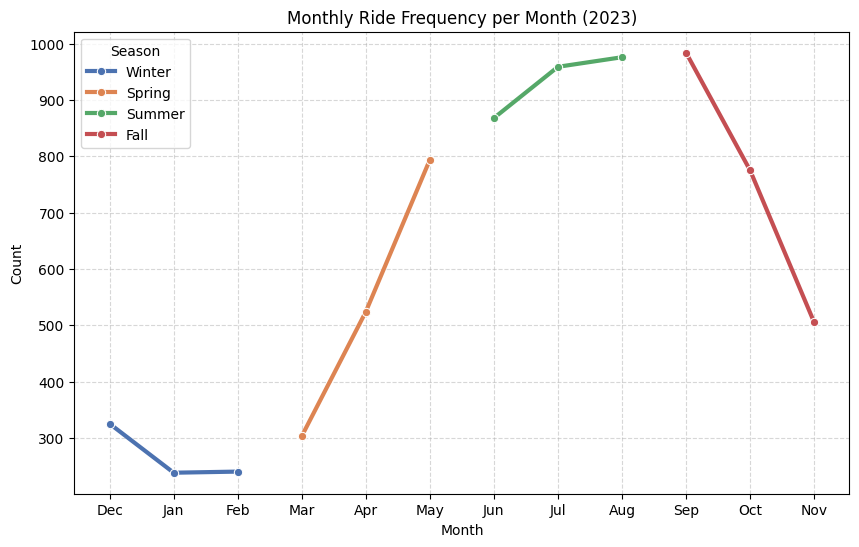

In [39]:
"""
sns.lineplot(
    data=season_df, 
    x='Month_Name', 
    y='Count', 
    hue='Season', 
    marker='o', 
    palette='rainbow', 
    linewidth=2.5  # Increase the linewidth for darker lines
)
If the lines still don’t appear dark enough, you can:

Use a different palette: The rainbow palette has bright colors; you might try dark or deep instead:

python
Copy
Edit
palette='dark'
Manually define darker colors:

python
Copy
Edit
palette=['darkblue', 'darkred', 'darkgreen', 'black']
Increase contrast with edgecolor (if markers are hard to see):

python
Copy
Edit
sns.lineplot(..., markerfacecolor='black', markeredgewidth=2)


"""
f = plt.figure(figsize=(10, 6))
sns.lineplot(data=season_df, x = season_df['Month_Name'], y='Count', hue='Season', marker='o', palette='deep', linewidth=3)

# Labels and title
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Monthly Ride Frequency per Month (2023)")
plt.xticks(range(0, 12))  # Show full range of hours
plt.legend(title="Season")

# Show plot
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig('images/fig5.png')

In [40]:
sample_df

,Trip id,Start Date (YYYY-MM-DD),Time Start,End Date (YYYY-MM-DD),Time End,Trip Duration (seconds),Start Station Id,Start Station Name,End Station Id,End Station Name,...,lon_start,lat_end,lon_end,Month,Day of Week,day_start,day_start_hour,day_start_minute,day_start_seconds,Season
0,20150036.0,2023-01-01,1900-01-01 05:06:00,2023-01-01,1900-01-01 05:08:00,134,7148,King St W / Joe Shuster Way,7148.0,King St W / Joe Shuster Way,...,-79.423611,43.639444,-79.423611,2023-01-01,Sunday,0 days 05:06:00,5,6,0,Winter
1,20150702.0,2023-01-01,1900-01-01 11:18:00,2023-01-01,1900-01-01 11:33:00,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322.0,King St W / Brant St,...,-79.430400,43.639278,-79.411574,2023-01-01,Sunday,0 days 11:18:00,11,18,0,Winter
2,20151407.0,2023-01-01,1900-01-01 15:03:00,2023-01-01,1900-01-01 15:05:00,126,7389,College Park- Gerrard Entrance,7012.0,Elizabeth St / Edward St (Bus Terminal),...,-79.383518,43.656026,-79.385327,2023-01-01,Sunday,0 days 15:03:00,15,3,0,Winter
3,20152688.0,2023-01-01,1900-01-01 20:42:00,2023-01-01,1900-01-01 21:07:00,1493,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7140.0,Macpherson Ave / Spadina Rd,...,-79.398253,43.675791,-79.406980,2023-01-01,Sunday,0 days 20:42:00,20,42,0,Winter
4,20153366.0,2023-01-02,1900-01-01 03:50:00,2023-01-02,1900-01-01 03:54:00,295,7238,Sorauren/Geoffrey (Sorauren Park) - SMART,7496.0,Sunnyside Ave / The Queensway - SMART,...,-79.444509,43.639700,-79.448650,2023-01-01,Monday,0 days 03:50:00,3,50,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,26674866.0,2023-12-30,1900-01-01 17:05:00,2023-12-30,1900-01-01 17:18:00,755,7016,Bay St / Queens Quay W (Ferry Terminal),7171.0,Ontario Place Blvd / Lake Shore Blvd W (East),...,-79.376785,43.632244,-79.410810,2023-12-01,Saturday,0 days 17:05:00,17,5,0,Winter
8108,26675490.0,2023-12-30,1900-01-01 18:17:00,2023-12-30,1900-01-01 18:29:00,678,7534,Walnut Ave / Queen St W,7334.0,Simcoe St / Wellington St North,...,-79.411084,43.646218,-79.385505,2023-12-01,Saturday,0 days 18:17:00,18,17,0,Winter
8109,26676732.0,2023-12-30,1900-01-01 22:05:00,2023-12-30,1900-01-01 22:13:00,500,7034,Church St / Bloor St E,7001.0,Wellesley Station Green P,...,-79.382919,43.664964,-79.383550,2023-12-01,Saturday,0 days 22:05:00,22,5,0,Winter
8110,26678773.0,2023-12-31,1900-01-01 11:46:00,2023-12-31,1900-01-01 11:54:00,483,7269,Toronto Eaton Centre (Yonge St),7324.0,King St W / Charlotte St (West Side),...,-79.380653,43.645572,-79.393990,2023-12-01,Sunday,0 days 11:46:00,11,46,0,Winter


In [41]:
locations.to_csv('datasets/locations.csv')

sample_df

,Trip id,Start Date (YYYY-MM-DD),Time Start,End Date (YYYY-MM-DD),Time End,Trip Duration (seconds),Start Station Id,Start Station Name,End Station Id,End Station Name,...,lon_start,lat_end,lon_end,Month,Day of Week,day_start,day_start_hour,day_start_minute,day_start_seconds,Season
0,20150036.0,2023-01-01,1900-01-01 05:06:00,2023-01-01,1900-01-01 05:08:00,134,7148,King St W / Joe Shuster Way,7148.0,King St W / Joe Shuster Way,...,-79.423611,43.639444,-79.423611,2023-01-01,Sunday,0 days 05:06:00,5,6,0,Winter
1,20150702.0,2023-01-01,1900-01-01 11:18:00,2023-01-01,1900-01-01 11:33:00,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322.0,King St W / Brant St,...,-79.430400,43.639278,-79.411574,2023-01-01,Sunday,0 days 11:18:00,11,18,0,Winter
2,20151407.0,2023-01-01,1900-01-01 15:03:00,2023-01-01,1900-01-01 15:05:00,126,7389,College Park- Gerrard Entrance,7012.0,Elizabeth St / Edward St (Bus Terminal),...,-79.383518,43.656026,-79.385327,2023-01-01,Sunday,0 days 15:03:00,15,3,0,Winter
3,20152688.0,2023-01-01,1900-01-01 20:42:00,2023-01-01,1900-01-01 21:07:00,1493,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7140.0,Macpherson Ave / Spadina Rd,...,-79.398253,43.675791,-79.406980,2023-01-01,Sunday,0 days 20:42:00,20,42,0,Winter
4,20153366.0,2023-01-02,1900-01-01 03:50:00,2023-01-02,1900-01-01 03:54:00,295,7238,Sorauren/Geoffrey (Sorauren Park) - SMART,7496.0,Sunnyside Ave / The Queensway - SMART,...,-79.444509,43.639700,-79.448650,2023-01-01,Monday,0 days 03:50:00,3,50,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,26674866.0,2023-12-30,1900-01-01 17:05:00,2023-12-30,1900-01-01 17:18:00,755,7016,Bay St / Queens Quay W (Ferry Terminal),7171.0,Ontario Place Blvd / Lake Shore Blvd W (East),...,-79.376785,43.632244,-79.410810,2023-12-01,Saturday,0 days 17:05:00,17,5,0,Winter
8108,26675490.0,2023-12-30,1900-01-01 18:17:00,2023-12-30,1900-01-01 18:29:00,678,7534,Walnut Ave / Queen St W,7334.0,Simcoe St / Wellington St North,...,-79.411084,43.646218,-79.385505,2023-12-01,Saturday,0 days 18:17:00,18,17,0,Winter
8109,26676732.0,2023-12-30,1900-01-01 22:05:00,2023-12-30,1900-01-01 22:13:00,500,7034,Church St / Bloor St E,7001.0,Wellesley Station Green P,...,-79.382919,43.664964,-79.383550,2023-12-01,Saturday,0 days 22:05:00,22,5,0,Winter
8110,26678773.0,2023-12-31,1900-01-01 11:46:00,2023-12-31,1900-01-01 11:54:00,483,7269,Toronto Eaton Centre (Yonge St),7324.0,King St W / Charlotte St (West Side),...,-79.380653,43.645572,-79.393990,2023-12-01,Sunday,0 days 11:46:00,11,46,0,Winter


In [42]:
sample_df['End Station Id'] = sample_df['End Station Id'].astype(np.int64)
sample_df

,Trip id,Start Date (YYYY-MM-DD),Time Start,End Date (YYYY-MM-DD),Time End,Trip Duration (seconds),Start Station Id,Start Station Name,End Station Id,End Station Name,...,lon_start,lat_end,lon_end,Month,Day of Week,day_start,day_start_hour,day_start_minute,day_start_seconds,Season
0,20150036.0,2023-01-01,1900-01-01 05:06:00,2023-01-01,1900-01-01 05:08:00,134,7148,King St W / Joe Shuster Way,7148,King St W / Joe Shuster Way,...,-79.423611,43.639444,-79.423611,2023-01-01,Sunday,0 days 05:06:00,5,6,0,Winter
1,20150702.0,2023-01-01,1900-01-01 11:18:00,2023-01-01,1900-01-01 11:33:00,900,7227,Martin Goodman Trail (Marilyn Bell Park),7322,King St W / Brant St,...,-79.430400,43.639278,-79.411574,2023-01-01,Sunday,0 days 11:18:00,11,18,0,Winter
2,20151407.0,2023-01-01,1900-01-01 15:03:00,2023-01-01,1900-01-01 15:05:00,126,7389,College Park- Gerrard Entrance,7012,Elizabeth St / Edward St (Bus Terminal),...,-79.383518,43.656026,-79.385327,2023-01-01,Sunday,0 days 15:03:00,15,3,0,Winter
3,20152688.0,2023-01-01,1900-01-01 20:42:00,2023-01-01,1900-01-01 21:07:00,1493,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7140,Macpherson Ave / Spadina Rd,...,-79.398253,43.675791,-79.406980,2023-01-01,Sunday,0 days 20:42:00,20,42,0,Winter
4,20153366.0,2023-01-02,1900-01-01 03:50:00,2023-01-02,1900-01-01 03:54:00,295,7238,Sorauren/Geoffrey (Sorauren Park) - SMART,7496,Sunnyside Ave / The Queensway - SMART,...,-79.444509,43.639700,-79.448650,2023-01-01,Monday,0 days 03:50:00,3,50,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,26674866.0,2023-12-30,1900-01-01 17:05:00,2023-12-30,1900-01-01 17:18:00,755,7016,Bay St / Queens Quay W (Ferry Terminal),7171,Ontario Place Blvd / Lake Shore Blvd W (East),...,-79.376785,43.632244,-79.410810,2023-12-01,Saturday,0 days 17:05:00,17,5,0,Winter
8108,26675490.0,2023-12-30,1900-01-01 18:17:00,2023-12-30,1900-01-01 18:29:00,678,7534,Walnut Ave / Queen St W,7334,Simcoe St / Wellington St North,...,-79.411084,43.646218,-79.385505,2023-12-01,Saturday,0 days 18:17:00,18,17,0,Winter
8109,26676732.0,2023-12-30,1900-01-01 22:05:00,2023-12-30,1900-01-01 22:13:00,500,7034,Church St / Bloor St E,7001,Wellesley Station Green P,...,-79.382919,43.664964,-79.383550,2023-12-01,Saturday,0 days 22:05:00,22,5,0,Winter
8110,26678773.0,2023-12-31,1900-01-01 11:46:00,2023-12-31,1900-01-01 11:54:00,483,7269,Toronto Eaton Centre (Yonge St),7324,King St W / Charlotte St (West Side),...,-79.380653,43.645572,-79.393990,2023-12-01,Sunday,0 days 11:46:00,11,46,0,Winter


In [43]:
new_locations = sample_df[['lat_start', 'lon_start', 'lat_end', 'lon_end']]
new_locations.isna().sum()

lat_start    0
lon_start    0
lat_end      0
lon_end      0
dtype: int64

In [44]:
# Create a folium map centered at the mean location
m = folium.Map(location=[sample_df['lat_start'].mean(), sample_df['lon_start'].mean()], zoom_start=10)

# Add HeatMap layer
heat_data = sample_df[['lat_start', 'lon_start']].values.tolist()
HeatMap(heat_data).add_to(m)

# Save and display the map
m.save("images/heatmap.html")
m

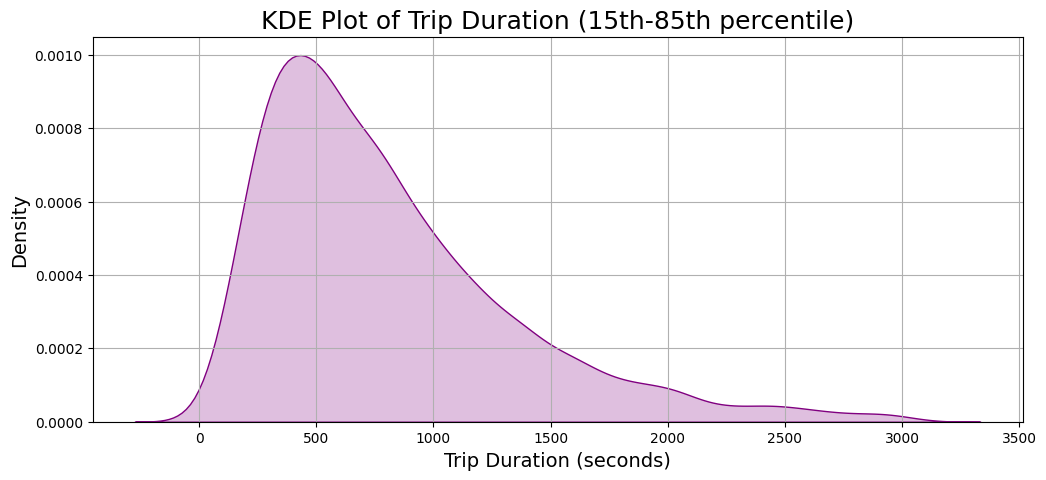

In [127]:
# We would like to visualize the distribution of bikeshare trip duration minus any extreme outliers, therefore we choose Kernel Density Estimation plotting.
df=sample_df

df['Trip Duration (seconds)']=pd.to_numeric(df['Trip Duration (seconds)'], errors='coerce')   #converts any non-numeric values into NaN
df = df.dropna(subset=['Trip Duration (seconds)'])   #removes any rows that have missing values in the trip duration column

Q1 = df['Trip Duration (seconds)'].quantile(0.15)   #lower band of trip duration at 15th percentile, excludes any outliers below it
Q3 = df['Trip Duration (seconds)'].quantile(0.85)   #upper band of trip duration at 85th percentile, excludes any outliers above it
IQR = Q3-Q1   # measuring Interquartile range

filtered_df = df[(df['Trip Duration (seconds)']  >= Q1 - 1.5*IQR) &
                 (df['Trip Duration (seconds)']  <= Q3 + 1.5*IQR)]   #removes all outliers outside of this range

#Plot KDE with the filtered data
plt.figure(figsize=(12,5))
sns.kdeplot(filtered_df['Trip Duration (seconds)'], fill=True, color='purple')

plt.title('KDE Plot of Trip Duration (15th-85th percentile)', fontsize=18)
plt.xlabel('Trip Duration (seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True)
plt.show

plt.savefig('images/fig6.png')

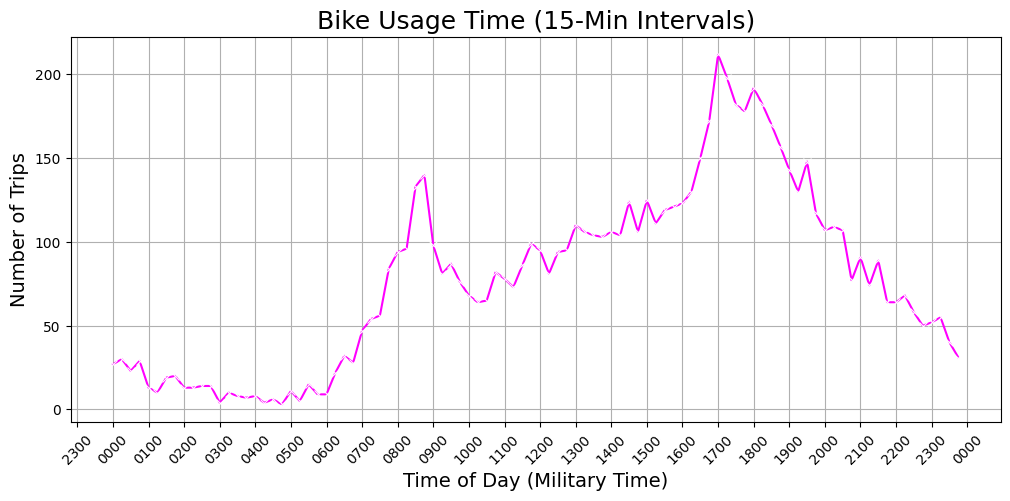

<Figure size 640x480 with 0 Axes>

In [138]:
# time-of-day trip duration visualization analysis
import matplotlib.dates as mdates  #for military time for better visualisation

#ensure 'time start' to datetime format
df['Time Start'] = pd.to_datetime(df['Time Start'], errors='coerce')

#group by 15 minute intervals and count the number of trips
df['Time_15min'] = df['Time Start'].dt.floor('15min')
time_series_15minute = df.groupby('Time_15min').size().reset_index(name='number of trips')

#plot using seaborn
plt.figure(figsize=(12,5))
sns.lineplot(data=time_series_15minute, x='Time_15min', y='number of trips', marker = 'x', color = 'Magenta')

#configuring the chart stuff
plt.title('Bike Usage Time (15-Min Intervals)', fontsize = 18)
plt.xlabel('Time of Day (Military Time)', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H%M'))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.savefig('images/fig7.png')
plt.show()

In [139]:
# make a stacked area chart for the top 30 stations by trip count, showing bike usage during different hours.

# Calculate trip counts
station_trip_counts = df['Start Station Id'].value_counts()

# Convert to DataFrame
station_trip_counts = station_trip_counts.reset_index()
station_trip_counts.columns = ['Start Station Id', 'Trip Count']

# Sort by trip count in descending order and select top 30
station_trip_counts = station_trip_counts.sort_values(by='Trip Count', ascending=False).head(30)

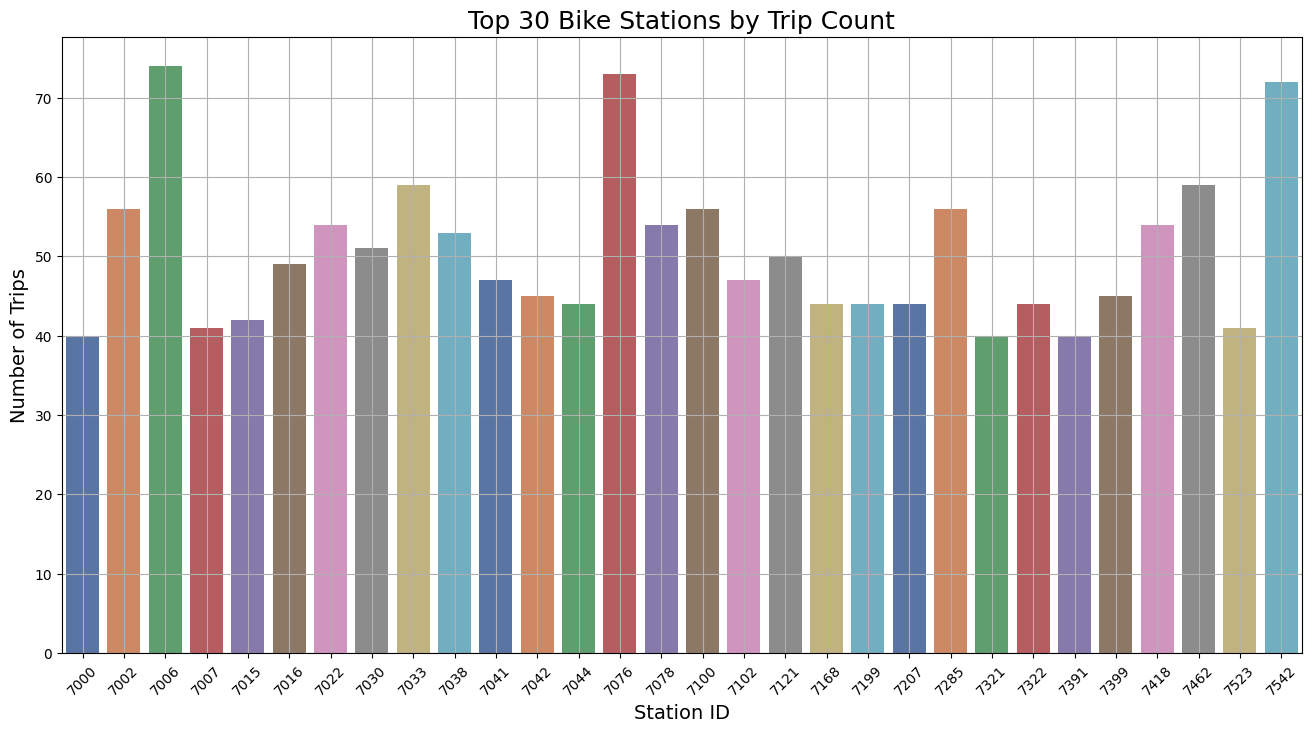

<Figure size 640x480 with 0 Axes>

In [144]:
# Plot the bar chart
plt.figure(figsize=(16, 8))
sns.barplot(data=station_trip_counts, x='Start Station Id', y='Trip Count', hue='Start Station Id', palette='deep', legend=False)

plt.title('Top 30 Bike Stations by Trip Count', fontsize=18)
plt.xlabel('Station ID', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.savefig('images/fig8.png')
plt.show()

In [ ]:
testing testing

In [90]:
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################